In [125]:
import gym
import math
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from skopt.optimizer import gp_minimize
from skopt.space import Real, Integer
from skopt.utils import use_named_args
from sklearn.preprocessing import KBinsDiscretizer
np.random.seed(0)

In [54]:
# Create the environment and set a seed to work in 
env = gym.make('CartPole-v1')
env.seed(0)

[0]

In [4]:
# Run this code to see how the CartPole problem looks and notce the 4 variables cart position, cart velocity, pole angle, pole velocity visualized using env.render
for _ in range(3):
    env.reset()
    for _ in range(200):
        env.step(env.action_space.sample())
        env.render()
env.close()

C:\Users\Taha\anaconda3\lib\site-packages\gym\logger.py:30: UserWarning: WARN: You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


In [5]:
# Run this cell to get information on the environment which in this case is CartPole-v1 but works with other openai gym environments
# Try running gym.make with 'MountainCar-v0' or 'FrozenLake-v0'
?env.env 

Type:        CartPoleEnv
String form: <CartPoleEnv<CartPole-v1>>
File:        c:\users\taha\anaconda3\lib\site-packages\gym\envs\classic_control\cartpole.py
Docstring:  
Description:
    A pole is attached by an un-actuated joint to a cart, which moves along
    a frictionless track. The pendulum starts upright, and the goal is to
    prevent it from falling over by increasing and reducing the cart's
    velocity.

Source:
    This environment corresponds to the version of the cart-pole problem
    described by Barto, Sutton, and Anderson

Observation:
    Type: Box(4)
    Num     Observation               Min                     Max
    0       Cart Position             -4.8                    4.8
    1       Cart Velocity             -Inf                    Inf
    2       Pole Angle                -0.418 rad (-24 deg)    0.418 rad (24 deg)
    3       Pole Angular Velocity     -Inf                    Inf

Actions:
    Type: Discrete(2)
    Num   Action
    0     Push cart to the lef

#### https://github.com/openai/gym/wiki/CartPole-v0

This link has all the information regarding the specifics of the CartPole environment. The action space, how rewards are disitributed, and what it means to solve this problem are all very important to understand when attempting this problem.

Solved requirements: "Considered solved when the average reward is greater than or equal to 195.0 over 100 consecutive trials." 

We will be using the algorithm for Q-learning presented in Sutton & Barto (pg. 131)

In [6]:
%%html
<img src="ql.png" width=1000 height=10 />

## Q-Learning

We will first attempt to solve this problem with the Q-learning algorithm, which is an off-policy temporal difference control algorithm.

Off-policy means that we do not update or use an explicit policy when training our agent in the environment, but rather rely on our epsilon-greedy policy to explore the state space. 

The action-value function Q will directly approximate the optimal action-value function Q* following this algorithm. 

In [151]:
# The 4 variables in the observation space are continuous and in order to create a workable state-action space to work with we must divide the variables into 
# discrete bins. Keeping the pole at the correct angle is integral in collecting the most rewards and the cart velocity depends on the pole velocity, as stated 
# in the environment's overview. Only include the pole angle and pole velocity to simplify the state-action space. 

state_space = (6, 12)
lower_bounds = [env.observation_space.low[2], -math.radians(50)]
upper_bounds = [env.observation_space.high[2], math.radians(50)]

# This function takes an input of 4 float values, it will ignore the cart position and velocity and put the values of pole angle and velocity into discrete buckets
def bucketing(_, __, pole_angle, angular_velocity):
    estimator = KBinsDiscretizer(n_bins=state_space, encode='ordinal', strategy='uniform')
    estimator.fit([lower_bounds, upper_bounds])
    buckets = estimator.transform([[pole_angle, angular_velocity]])
    buckets = (map(int, buckets[0]))
    
    return tuple(buckets)

In [152]:
# Initialize the state-action function, Q, to 0 
Q_table = np.zeros(state_space + (env.action_space.n,))
Q_table.shape

(20, 5, 2)

In [154]:
tic = time.time()
reward_list = []  
plot_rewards = [] # This list will be used to plot rewards vs. episodes
episode_reward = 0
success = False
for i in range(1, 501):
    # Update the learning rate and epsilon value every episode
    lr = max(0.01, min(1.0, 1.0 - math.log10((i + 1) / 25)))
    epsilon = max(0.084584, min(1, 1.0 - math.log10((i  + 1) / 25)))
    
    # Use the bucketing function we made to initialize the starting state
    current = bucketing(*env.reset())
    done = False
    while not done:
        
        # Get the action for a given state using an epsilon-greedy 
        if np.random.random() < epsilon:
            action = env.action_space.sample()
        else:
            action = np.argmax(Q_table[current])
            
        # env.step(action) outputs 4 values: the next state, the rewards from the step, a Boolean that returns True if the next state is terminal and False 
        # otherwise, and a Dict that contains diagnostic information used for debugging (we will not be using this)
        observation, reward, done, info = env.step(action) 
        next_state = bucketing(*observation)
        
        # Update Q based on the Q-Learning algorithm
        Q_table[current][action] += lr*(reward + np.max(Q_table[next_state]) - Q_table[current][action])
        current = next_state
        
        # Increment the reward counters 
        episode_reward += reward
        
    plot_rewards.append(episode_reward)    
    reward_list.append(episode_reward)
    episode_reward = 0

    # Every 100 episodes check if the most recent rolling average satisfies the conditions in order to solve the environment
    if i >= 100:
        if np.mean(reward_list) >= 195.0:
            toc = time.time()
            success = True
            final_episode = i
            print(f'Took {toc-tic:.2f} seconds and achieved average reward of {np.mean(reward_list)} in {i} episodes')
            break
        del reward_list[0]
toc = time.time()
if not success:
    print(f'Took {toc-tic:.2f} seconds and failed')

Took 7.77 seconds and achieved average reward of 197.92 in 157 episodes


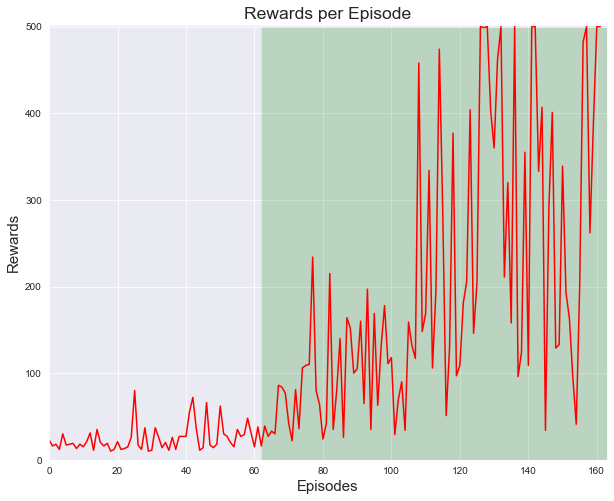

In [302]:
# 500 steps is the max for the environment and becomes terminal once that is reached
sns.set_style('darkgrid')
f, ax = plt.subplots(figsize=(10,8))
sns.lineplot(x=range(len(plot_rewards)), y=plot_rewards, ax=ax, color='r')
ax.set_title('Rewards per Episode', size=17.5)
ax.set_ylabel('Rewards', size=15)
ax.set_xlabel('Episodes', size=15)
ax.set_ylim(0, 502)
ax.set_xlim(0,final_episode+1)
ax.fill_between(range(final_episode-100, final_episode+5), 0, 500, facecolor='green', alpha=.2) # Shading the area that achieves the average reward

### Hyperparameter Optimization

We will use scikit-optimize (skopt) to perform hyperparameter optimization 

This entire process is very expensive since each function call takes a long time to complete

We will perform Bayesian optimization to try and counteract the expensive nature of training Q

gp_minimize uses a Gaussian process to approximate the function given, which in this case is the average_rewards function we will define below

In [140]:
# gp_minimize has a dimensions parameter where we pass a list of the ranges and names of our hyperparameters

search = []
search.append(Real(0.01, 0.2, name='min_epsilon'))
search.append(Real(0.1, 1, name='gamma'))
search.append(Real(0.01, 0.2, name='min_lr'))
search.append(Integer(2, 20, name='pole_angle_bins'))
search.append(Integer(2, 20, name='angular_velocity_bins'))

In [141]:
# Define a new bucketing function that passes two new parameters for the bins of the observation space variables

lower_bounds = [env.observation_space.low[2], -math.radians(50)]
upper_bounds = [env.observation_space.high[2], math.radians(50)]

def bucketing_new(_, __, pole_angle, angular_velocity, pole_angle_bins, angular_velocity_bins):
    estimator = KBinsDiscretizer(n_bins=(pole_angle_bins, angular_velocity_bins), encode='ordinal', strategy='uniform')
    estimator.fit([lower_bounds, upper_bounds])
    buckets = estimator.transform([[pole_angle, angular_velocity]])
    buckets = (map(int, buckets[0]))
    return tuple(buckets)

In [142]:
# Define an function that uses the hyperparameters from our search list 
# Over the course of the training in the function we record each episode's rewards and once there are 100 rewards we start a rolling average over 100 episodes
# average_returns returns (500 - the mean of all those rolling averages) which we will try to minimize so we can find the hyperparameters that maximize that mean

@use_named_args(search)
def average_rewards(min_epsilon, gamma, min_lr, pole_angle_bins, angular_velocity_bins):
    Q_table = np.zeros((pole_angle_bins, angular_velocity_bins) + (env.action_space.n,))
    reward_list = []
    episodic = []
        
    for i in range(1, 500+1):
        episode_reward = 0
            
        lr = max(min_lr, min(1.0, 1.0 - math.log10((i + 1) / 25)))
        epsilon = max(min_epsilon, min(1, 1.0 - math.log10((i  + 1) / 25)))
            
        current = bucketing_new(*env.reset(), pole_angle_bins, angular_velocity_bins)
        done = False
        while not done:
            if np.random.random() < epsilon:
                action = env.action_space.sample()
            else:
                action = np.argmax(Q_table[current])
            
            observation, reward, done, info = env.step(action) 
            next_state = bucketing_new(*observation, pole_angle_bins, angular_velocity_bins)
                
            Q_table[current][action] += lr*(reward + (gamma*np.max(Q_table[next_state])) - Q_table[current][action])
                
            current = next_state
            episode_reward += reward
             

        reward_list.append(episode_reward)
            
        if i >= 100:
            episodic.append(np.mean(reward_list))
            del reward_list[0]

    return 500 - np.mean(episodic)

In [143]:
result = gp_minimize(func=average_rewards, dimensions=search)

In [144]:
print(f'Highest Average Reward: {500.0 - result.fun:.2f}')
print('--------------------------------------------')
print(pd.DataFrame(data=result.x, index=['Minimum Epsilon', 'Gamma', 'Minimum Learning Rate', 'Pole Angle Bins', 'Pole Angular Velocity Bins'], 
                   columns=['Best Hyperparameters']))

Highest Average Reward: 419.48
--------------------------------------------
                            Best Hyperparameters
Minimum Epsilon                         0.084584
Gamma                                   1.000000
Minimum Learning Rate                   0.010000
Pole Angle Bins                        20.000000
Pole Angular Velocity Bins              5.000000


#### Let us organize everything into a class and use these results

In [145]:
class QLearningAgent():
    
    def __init__(self, env, pole_angle_bins, angular_velocity_bins, min_epsilon, gamma, min_lr):
        
        self.env = env
        self.state_space = (pole_angle_bins, angular_velocity_bins)
        self.min_epsilon = min_epsilon
        self.gamma = gamma
        self.min_lr = min_lr
        
    def bucketing(self, _, __, pole_angle, angular_velocity):
        lower_bounds = [self.env.observation_space.low[2], -math.radians(50)]
        upper_bounds = [self.env.observation_space.high[2], math.radians(50)]
        
        estimator = KBinsDiscretizer(n_bins=(self.state_space), encode='ordinal', strategy='uniform')
        estimator.fit([lower_bounds, upper_bounds])
        buckets = estimator.transform([[pole_angle, angular_velocity]])
        buckets = (map(int, buckets[0]))
        return tuple(buckets)
        
    def update_learning_rate(self, episode):
        self.learning_rate =  max(self.min_lr, min(1, 1.0 - math.log10((episode  + 1) / 25)))
    
    def update_epsilon_greedy(self, episode):
        self.epsilon =  max(self.min_epsilon, min(1, 1.0 - math.log10((episode  + 1) / 25)))
    
    def get_action(self, state):
        if np.random.random() < self.epsilon:
            action = self.env.action_space.sample()
        else:
            action = np.argmax(self.Q_table[state])
        return action
    
    def train_Q(self, episodes, visualize=False):
        tic = time.time()
        self.Q_table = np.zeros(self.state_space + (self.env.action_space.n,))
        self.reward_list = []
        self.plot_rewards = []
        episode_reward = 0
        success = False
        for i in range(1, episodes+1):
            self.update_learning_rate(i)
            self.update_epsilon_greedy(i)
            current = self.bucketing(*self.env.reset())
            done = False
            while not done:
                action = self.get_action(current)
                
                observation, reward, done, info = self.env.step(action) 
                next_state = self.bucketing(*observation)
                
                self.Q_table[current][action] += self.learning_rate*(reward + np.max(self.Q_table[next_state]) - self.Q_table[current][action])
                
                current = next_state
                episode_reward += reward
                
                if visualize:
                    env.render()
                
            self.reward_list.append(episode_reward)
            self.plot_rewards.append(episode_reward)
            episode_reward = 0
            
            if i >= 100:
                if np.mean(self.reward_list) >= 195.0:
                    toc = time.time()
                    success = True
                    self.final_train_episode = i
                    if visualize:
                        env.close()
                    return f'Took {toc-tic:.2f} seconds and achieved average reward of {np.mean(self.reward_list)} in {i} episodes'
                del self.reward_list[0]
        toc = time.time()
        if visualize:
            env.close()
        if not success:
            return f'Took {toc-tic:.2f} seconds and failed'

            
    def test_Q(self, episodes, visualize=False):
        """Test the state-action function to see if it achieves an average reward of 195.0 in 100 consecutive episodes"""
        tic = time.time()
        rewards = []
        episode_reward = 0
        for i in range(1, episodes+1):
            current = self.bucketing(*env.reset())
            done = False
            while not done:
                action = np.argmax(self.Q_table[current])
                observation, reward, done, info = env.step(action)
                next_state = self.bucketing(*observation)
                episode_reward += reward
                current = next_state
                if visualize:
                    env.render()
            rewards.append(episode_reward)
            episode_reward = 0
            if i >= 100:
                if np.mean(rewards) >= 195.0:
                    toc = time.time()
                    success = True
                    self.final_test_episode = i
                    if visualize:
                        env.close()
                    return f'Took {toc-tic:.2f} seconds and achieved average reward of {np.mean(self.reward_list)} in {i} episodes'
                del self.reward_list[0]
        toc = time.time()
        if visualize:
            env.close()
        if not success:
            return f'Took {toc-tic:.2f} seconds and failed'
        
        
    def plot_rewards_per_episode(self):
        f, ax = plt.subplots(figsize=(10,8))
        sns.lineplot(x=range(len(self.plot_rewards)), y=self.plot_rewards, ax=ax, color='r')
        ax.set_title('Rewards vs. Episodes')
        ax.set_title('Rewards per Episode', size=17.5)
        ax.set_ylabel('Rewards', size=15)
        ax.set_xlabel('Episodes', size=15)
        ax.set_ylim(0, 502)
        ax.set_xlim(0, self.final_train_episode+1)
        ax.fill_between(range(self.final_train_episode-100, self.final_train_episode+1), 0, 500, facecolor='green', alpha=.2) 

In [146]:
qlearn = QLearningAgent(env=gym.make('CartPole-v1'), 
                        pole_angle_bins=20, 
                        angular_velocity_bins=5, 
                        min_epsilon=0.084584, 
                        gamma=1.0, 
                        min_lr=0.01)

In [147]:
qlearn.train_Q(episodes=200)

'Took 7.98 seconds and achieved average reward of 199.21 in 167 episodes'

In [148]:
qlearn.test_Q(episodes=200)

'Took 17.58 seconds and achieved average reward of 199.21 in 100 episodes'

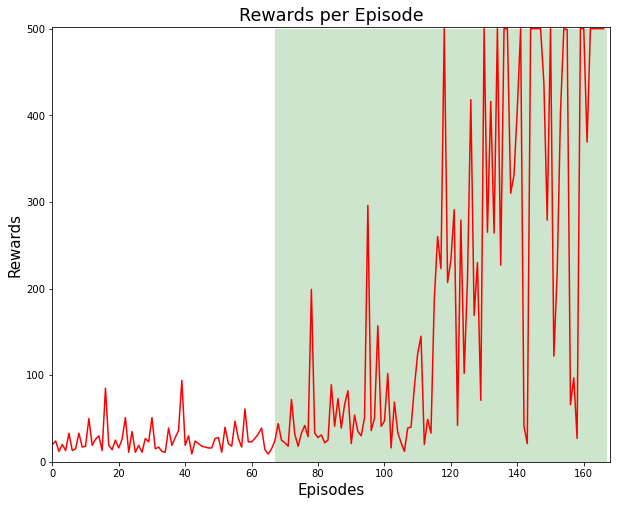

In [150]:
qlearn.plot_rewards_per_episode()

## References:

1)  Richard S. Sutton & Andrew G. Barto. (2018). Reinforcement Learning: An Introduction Second Edition.

2) Dr. David Silver. (2015). UCL Course on RL. Retrieved from https://www.davidsilver.uk/teaching/

3) Brockman, G., Cheung, V., Pettersson, L., Schneider, J., Schulman, J., Tang, J., & Zaremba, W. (2016). Openai gym. ArXiv Preprint ArXiv:1606.01540.
